In [1]:
import numpy as np
import matplotlib.pyplot as plt 

from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.experiment_container import new_experiment

from qcodes.instrument_drivers.tektronix.DPO7200xx import TektronixDPO7000xx

In [2]:
tek = TektronixDPO7000xx("tek3", "TCPIP0::10.193.36.56::inst0::INSTR")

Connected to: TEKTRONIX DPO72004C (serial:C600651, firmware:CF:91.1CT FV:10.8.3 Build 3) in 0.39s


In [3]:
initialise_database()
experiment = new_experiment(name='DPO_72000_example', sample_name="no sample")

In [26]:
tek.channel[0].set_trace_time(1.96E-3)

In [5]:
tek.waveform.bytes_per_sample(2)

In [6]:
encodings = [
    "ASCIi",
    "FAStest",
    "RIBinary",
    "RPBinary",
    "FPBinary",
    "SRIbinary",
    "SRPbinary",
    "SFPbinary",
]

In [7]:
tek.data.encoding(encodings[2])

Starting experimental run with id: 127


([<matplotlib.axes._subplots.AxesSubplot at 0x1d1b6290c50>,
 [None, None])

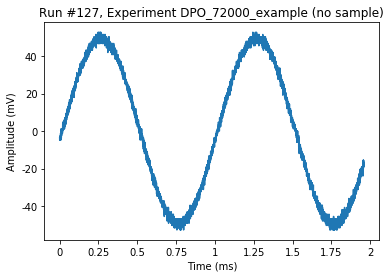

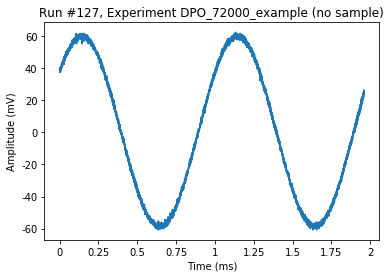

In [27]:
meas = Measurement(exp=experiment)
meas.register_parameter(tek.channel[0].trace)
meas.register_parameter(tek.channel[1].trace)

with meas.run() as datasaver:
    for i in [0, 1]:
        datasaver.add_result(
            (tek.channel[i].trace_axis, tek.channel[i].trace_axis()),
            (tek.channel[i].trace, tek.channel[i].trace())
        )

    dataid = datasaver.run_id

plot_by_id(dataid)

In [9]:
tek.measurement[0].source1("CH1")
tek.measurement[0].type("frequency")
value = tek.measurement[0].value()
unit = tek.measurement[0].value.unit

print(f"{value} {unit}")

999.73340442549 Hz


In [10]:
tek.measurement[0].type("amplitude")
value = tek.measurement[0].value()
unit = tek.measurement[0].value.unit

print(f"{value} {unit}")

0.09840000391006 V


In [11]:
tek.measurement[0].source1("CH2")
value = tek.measurement[0].value()
unit = tek.measurement[0].value.unit

print(f"{value} {unit}")

0.11680000826716 V


In [12]:
tek.measurement[0].source1("CH1")
tek.measurement[0].source2("CH2")
tek.measurement[0].type("phase")
value = tek.measurement[0].value()
unit = tek.measurement[0].value.unit

print(f"{value} {unit}")

-45.18858511275 °


# Future work 

The DPO7200xx scopes have support for mathematical operations. An example of a math operation is a spectral analysis. Although the current QCoDeS driver does not support these operations, the way the driver code has been factored should make it simple to add support if future need arrises. 

We provide an example below. We manually add a sprectrum analysis by selecting "math" -> "advanced spectral" from the the oscilloscope menu in the front display of the instrument. After manual creation, we can retrieve spectral data with the driver as follows: 

In [13]:
from qcodes.instrument_drivers.tektronix.DPO7200xx import TekronixDPOTrace

In [14]:
math_channel = TekronixDPOTrace(tek, "math", "MATH1")

Starting experimental run with id: 128


([<matplotlib.axes._subplots.AxesSubplot at 0x1d1b7327d30>], [None])

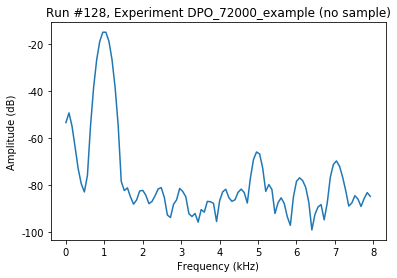

In [28]:
meas = Measurement(exp=experiment)
meas.register_parameter(math.trace)

with meas.run() as datasaver:

    datasaver.add_result(
        (math_channel.trace_axis, math_channel.trace_axis()),
        (math_channel.trace, math_channel.trace())
    )

    dataid = datasaver.run_id

plot_by_id(dataid)

In order to add full support for spectral analysis, we need to subclass `TekronixDPOTrace` and add parameters in the subclass which are specifically relevant to spectral analysis. For example, we will need a method to create a spectral analysis function and we need parameters which get/set frequency spans. 